In [10]:
# 1) install & authenticate Kaggle CLI
!pip install kaggle --quiet

from google.colab import files
files.upload()   # select your kaggle.json token from your local machine

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2) download & unzip the Digit Recognizer competition
COMPETITION = "digit-recognizer"   # https://www.kaggle.com/c/digit-recognizer/data
import os
os.makedirs(f"/kaggle/input/{COMPETITION}", exist_ok=True)

!kaggle competitions download -c {COMPETITION} -p /kaggle/input/{COMPETITION}
!unzip -q /kaggle/input/{COMPETITION}/*.zip -d /kaggle/input/{COMPETITION}

print("✅ Downloaded to /kaggle/input/digit-recognizer")


Saving kaggle.json to kaggle.json
  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 1.23GB/s]
✅ Downloaded to /kaggle/input/digit-recognizer


#### Imports

In [11]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [12]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

Check for CUDA

In [13]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

True
True
cuda


#### Read inputs

In [15]:
! ls /kaggle/input/

digit-recognizer


In [16]:
input_folder_path = "../kaggle/input/digit-recognizer/"
train_df = pd.read_csv(input_folder_path+"train.csv")
test_df = pd.read_csv(input_folder_path+"test.csv")

#### Separate into labels and training images and reshape the images

In [17]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     stratify=train_labels, random_state=123,
                                                                     test_size=0.20)

In [18]:
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

#### Plot some images to see samples

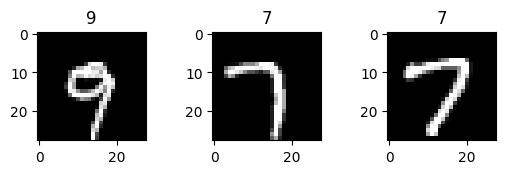

In [19]:
#train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

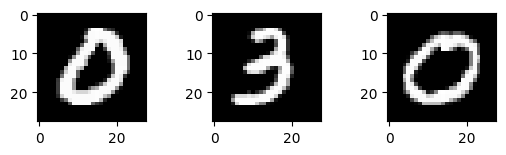

In [20]:
#test samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

#### Convert images to tensors
Normalize the images too

In [21]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

#test
test_images_tensor = torch.tensor(test_images)/255.0

#### Load images into the data generator

In [22]:
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

#### Plot some sample images using the data generator

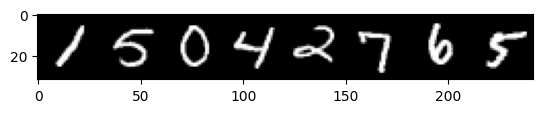

In [23]:
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1), nrow=8)
    img_target_labels = target[0:8,].numpy()
    break

plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
#plt.title(img_target_labels, size=16)
plt.show()

#### Define the CNN Model

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)

        return x

In [25]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### Define the optimizer and loss functions

In [26]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

#### Training the Model

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Epoch: 1 [1600/33600 (5%)]	Loss: 1.330473
Train Epoch: 1 [3200/33600 (10%)]	Loss: 0.561491
Train Epoch: 1 [4800/33600 (14%)]	Loss: 0.481201
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.340624
Train Epoch: 1 [8000/33600 (24%)]	Loss: 0.981696
Train Epoch: 1 [9600/33600 (29%)]	Loss: 0.107524
Train Epoch: 1 [11200/33600 (33%)]	Loss: 0.299578
Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.430425
Train Epoch: 1 [14400/33600 (43%)]	Loss: 0.156863
Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.377413
Train Epoch: 1 [17600/33600 (52%)]	Loss: 0.222076
Train Epoch: 1 [19200/33600 (57%)]	Loss: 0.214559
Train Epoch: 1 [20800/33600 (62%)]	Loss: 0.255587
Train Epoch: 1 [22400/33600 (67%)]	Loss: 0.122487
Train Epoch: 1 [24000/33600 (71%)]	Loss: 0.214925
Train Epoch: 1 [25600/33600 (76%)]	Loss: 0.306431
Train Epoch: 1 [27200/33600 (81%)]	Loss: 0.176209
Train Epoch: 1 [28800/33600 (86%)]	Loss: 0.029221
Train Epoch: 1 [30400/33600 (90%)]	Loss: 0.134048
Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.146903
Train E

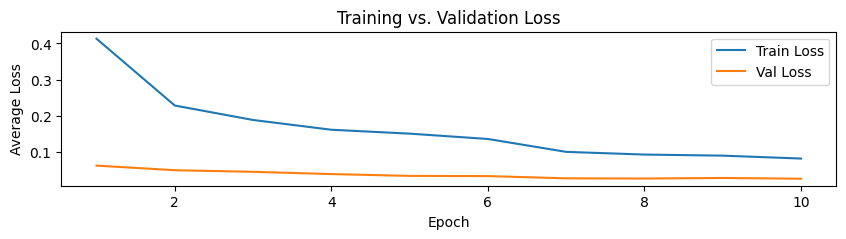

In [27]:
import matplotlib.pyplot as plt

# 1) Prepare containers
train_losses = []
val_losses   = []

# 2) Modify train_model to return the epoch’s avg loss
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()

    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

        if (batch_idx + 1) % 100 == 0:
            print(f'Train Epoch: {num_epoch} '
                  f'[{(batch_idx+1)*len(data)}/{len(train_loader.dataset)} '
                  f'({100.*(batch_idx+1)/len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.6f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


# 3) Modify evaluate to return avg val loss
def evaluate(data_loader):
    conv_model.eval()
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.unsqueeze(1)
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = conv_model(data)
            # sum up batch loss
            running_loss += F.cross_entropy(output, target, reduction='sum').item()
            # count correct
            pred = output.argmax(dim=1, keepdim=False)
            correct += pred.eq(target).sum().item()

    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * correct / len(data_loader.dataset)
    print(f'\nVal  Epoch Loss: {avg_loss:.4f}, Acc: {correct}/{len(data_loader.dataset)} ({accuracy:.2f}%)\n')
    return avg_loss


# 4) Outer loop over epochs, collecting losses
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_model(epoch)
    val_loss   = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


# 5) Plot both curves
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


#### Make predictions on the test set

In [ ]:
def make_predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()

    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)

        if torch.cuda.is_available():
            data = data.cuda()

        output = conv_model(data)

        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)

    return test_preds

In [ ]:
test_set_preds = make_predictions(test_loader)

#### Prepare Submissions

In [ ]:
submission_df = pd.read_csv("../kaggle/input/digit-recognizer/sample_submission.csv")

In [ ]:
submission_df['Label'] = test_set_preds.numpy().squeeze()
submission_df.head()

In [ ]:
submission_df.to_csv('../kaggle/input/digit-recognizer/submission.csv', index=False)